# Load AutoLaparo

In [1]:
import os
import sys
sys.path.append("../..")

import pandas as pd


from utils.io import load_yaml

server = "local"
server = load_yaml("../../config/servers.yml")[server]
database = "autolaparo_single_frames/AutoLaparo_Task2"
prefix = os.path.join(server["database"]["location"], database)

vid_df = pd.read_pickle(os.path.join(prefix, "log.pkl"))
label_df = pd.read_csv(os.path.join(prefix, "laparoscope_motion_label.csv"))

print(vid_df)
print(label_df)

# from readme
motion_dict = {
    0: "Static",
    1: "Up",
    2: "Down",
    3: "Left",
    4: "Right",
    5: "Zoom-in",
    6: "Zoom-out",
}

/home/martin/miniconda3/envs/torch110/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/martin/miniconda3/envs/torch110/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /home/martin/miniconda3/envs/torch110/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


Reading file from ../../config/servers.yml
        folder           file  vid frame
0        vid_0    frame_0.npy    0     0
1        vid_0    frame_1.npy    0     1
2        vid_0    frame_2.npy    0     2
3        vid_0    frame_3.npy    0     3
4        vid_0    frame_4.npy    0     4
...        ...            ...  ...   ...
74995  vid_299  frame_245.npy  299   245
74996  vid_299  frame_246.npy  299   246
74997  vid_299  frame_247.npy  299   247
74998  vid_299  frame_248.npy  299   248
74999  vid_299  frame_249.npy  299   249

[75000 rows x 4 columns]
     Clip   Label   Phase
0       1       5       2
1       2       6       2
2       3       2       2
3       4       2       2
4       5       3       2
..    ...     ...     ...
295   296       2       4
296   297       2       4
297   298       2       4
298   299       0       2
299   300       0       4

[300 rows x 3 columns]


# Load Homography Predictor

In [2]:
from lightning_modules.homography_imitation import ConvHomographyPredictorModule

checkpoint_prefix = "/home/martin/Tresors/homography_imitation_learning_logs/miccai/cross_val/cholec80/resnet34/version_0"
checkpoint = "checkpoints/epoch=48-step=172578.ckpt"
config = load_yaml(os.path.join(checkpoint_prefix, "config.yml"))

module = ConvHomographyPredictorModule.load_from_checkpoint(
    os.path.join(checkpoint_prefix, checkpoint), **config["model"]
)

Reading file from /home/martin/Tresors/homography_imitation_learning_logs/miccai/cross_val/cholec80/resnet34/version_0/config.yml


/home/martin/miniconda3/envs/torch110/lib/python3.9/site-packages/pytorch_lightning/utilities/migration/utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v1.9.1, which is newer than your current Lightning version: v1.9.0
  rank_zero_warn(


Adjusting learning rate of group 0 to 1.0000e-03.


tensor([[[ 5.5660,  2.6820],
         [-2.9976, -4.8187],
         [-6.8015, -0.0568],
         [-4.8156, -0.0737]]], grad_fn=<ViewBackward0>)


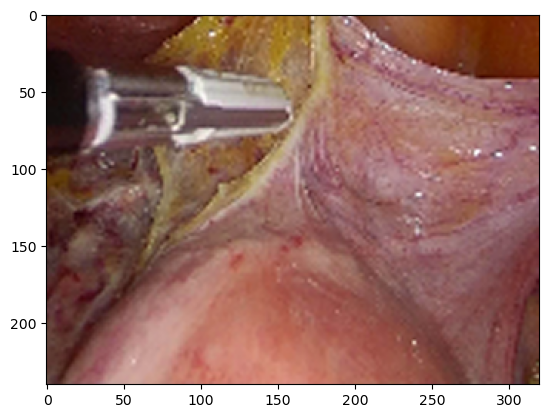

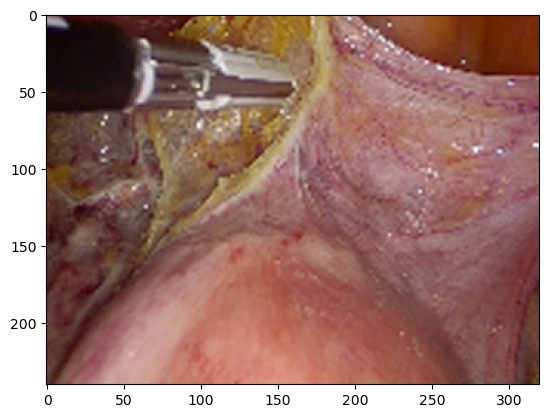

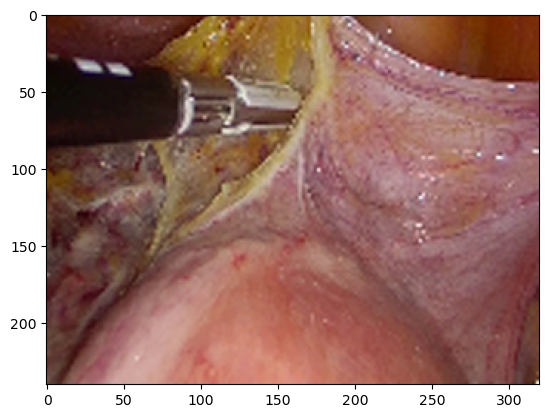

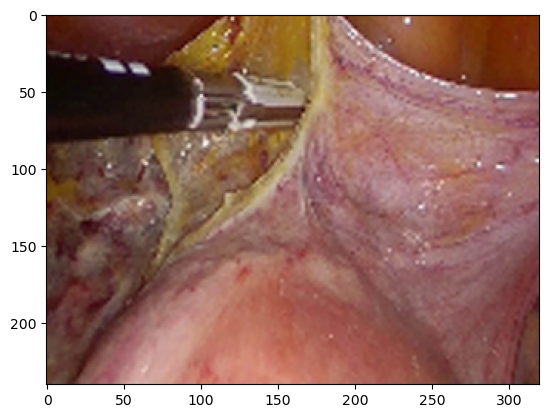

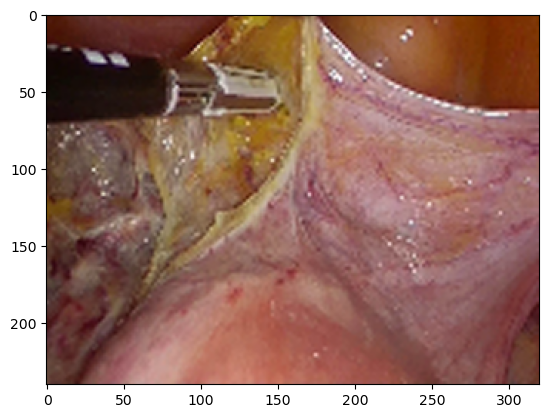

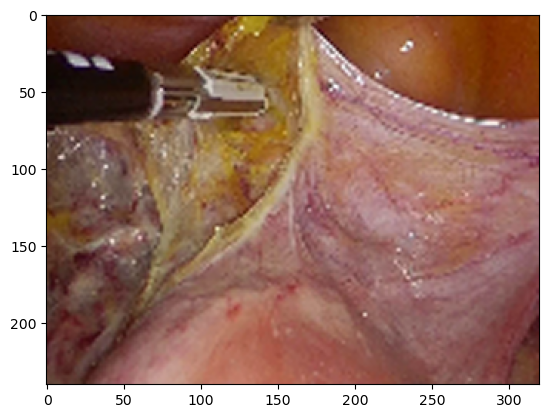

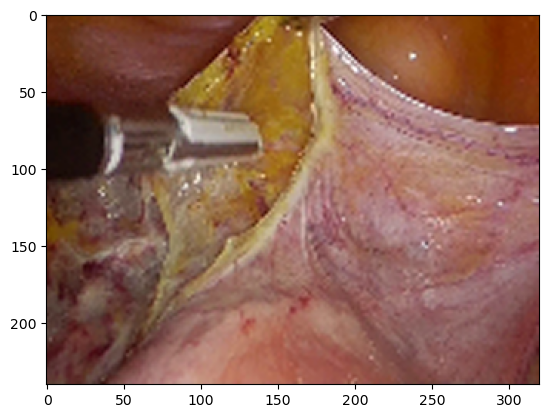

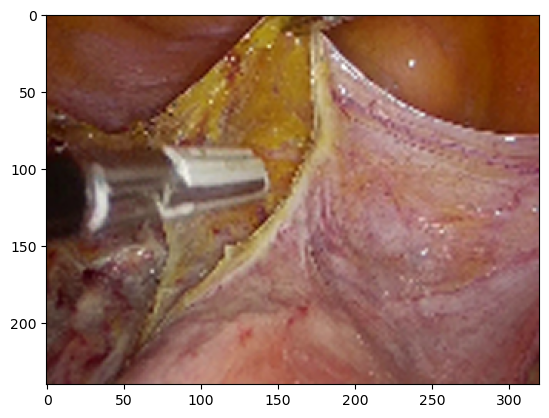

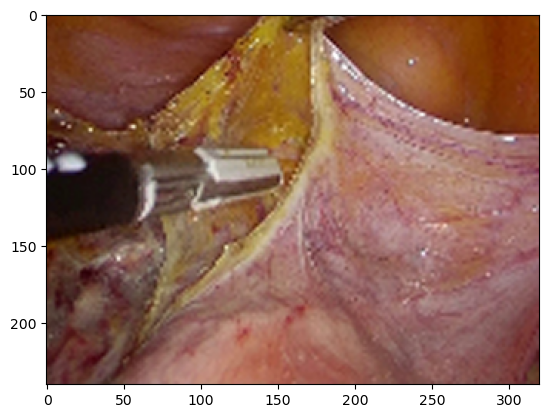

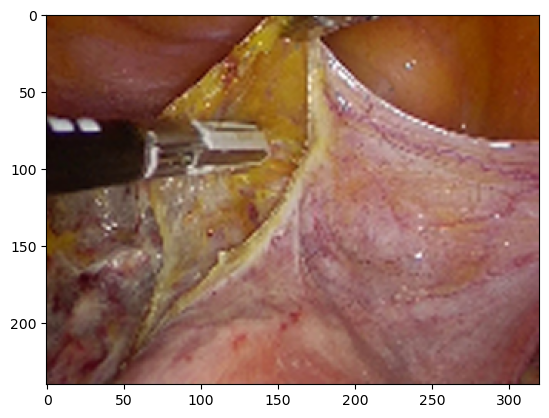

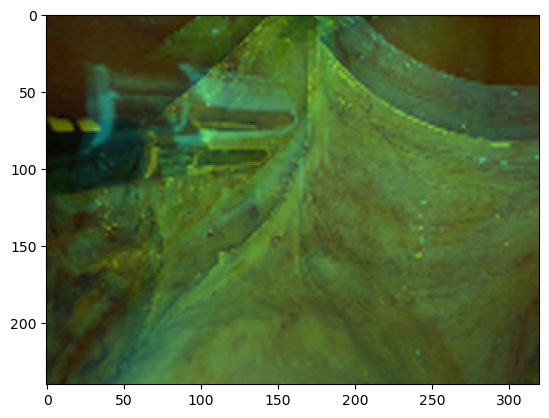

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from kornia import tensor_to_image
from torch.utils.data import DataLoader
from datasets import ImageSequenceDataset

from utils.viz import create_blend_from_four_point_homography
from utils.transforms import dict_list_to_augment

transforms = dict_list_to_augment([
    {"chance": 1.0, "module": "imgaug.augmenters", "type": "Resize", "kwargs": {"size": {"height": 240, "width": 320}}}
])

ds = ImageSequenceDataset(
    df=vid_df,
    prefix=prefix,
    seq_len=10,
    frame_increment=5,
    frames_between_clips=10,
    geometric_transforms=transforms,
)

dl = DataLoader(ds, batch_size=1, shuffle=False, num_workers=0)

for batch in dl:
    imgs, imgs_tf, frame_idcs, vid_idx = batch
    B, T, C, H, W = imgs.shape
    imgs = imgs.float() / 255.

    input = imgs[:, :-1]
    input = input.reshape(B, -1, H, W)
    duv = module(input)
    print(duv)

    # direction lsos
    blend = create_blend_from_four_point_homography(imgs[:, 0], imgs[:, -1], duv)
    blend = (tensor_to_image(blend, keepdim=False) * 255.).astype(np.uint8)
    
    for img in imgs[0]:
        img = tensor_to_image(img, keepdim=False)
        plt.imshow(img)
        plt.show()
    
    plt.imshow(blend)
    plt.show()
    break

    # for img in imgs[0]:
    #     img = tensor_to_image(img, keepdim=False)
    #     plt.imshow(img)
    #     plt.show()

    # break
